In [1]:
import numpy as np
from astropy.convolution.kernels import CustomKernel
def Gaussian3DKernel(x_stddev,y_stddev=None,z_stddev=None):
    if y_stddev is None:
        y_stddev = x_stddev
    if z_stddev is None:
        z_stddev = x_stddev
    size=4*np.array([x_stddev,y_stddev,z_stddev])
    shape=2*size+1
    array=np.zeros([shape[0],shape[1],shape[2]])
    print(size,shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                array[i,j,k]=1./(2*np.pi * x_stddev * y_stddev * z_stddev)**1.5 * np.exp(-(((i-size[0])/x_stddev)**2 + ((j-size[1])/y_stddev)**2 + ((k-size[2])/z_stddev)**2)/2)
    kernel=CustomKernel(array)
    return kernel
kernel3D=Gaussian3DKernel(10,3,3)

[40 12 12] [81 25 25]


In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
hdul=fits.open('GCHVC_imcontsub.fits')
from astropy.convolution import convolve

In [3]:
kernel3D=Gaussian3DKernel(5,3,3)
#cube=convolve(hdul[0].data,Gaussian3DKernel(3,2,2))
#hdul[0].data=cube
#hdul.writeto('GCHVC_imcontsub_convolved.fits')
hdul=fits.open('GCHVC_imcontsub_convolved.fits')
cube=hdul[0].data

[20 12 12] [41 25 25]


In [4]:
result=np.loadtxt('results.txt',dtype='str')

In [5]:
colnamestr='ObjID       Name     X     Y      Z         RA       DEC         RA        DEC           FREQ    MAJ     MIN      PA     w_RA    w_DEC        w_50        w_20      w_FREQ            F_int     eF_int         F_tot    eF_tot    F_peak   S/Nmax  X1  X2  Y1  Y2   Z1   Z2   Nvoxel Nchan Nspatpix Flag  X_av  Y_av   Z_av X_cent Y_cent Z_cent X_peak Y_peak Z_peak'

In [6]:
colnames=colnamestr.split(' ')
colnames=[colnames[i] for i in range(len(colnames)) if colnames[i]!='']

In [7]:
import pandas as pd

In [8]:
colnames
colnames[7]='RA_d'
colnames[8]='DEC_d'

In [9]:
resulttb=pd.DataFrame(result,columns=colnames)

In [10]:
result_hisnr=resulttb[resulttb['S/Nmax'].astype(float)>3]

In [11]:
len(result_hisnr)

1749

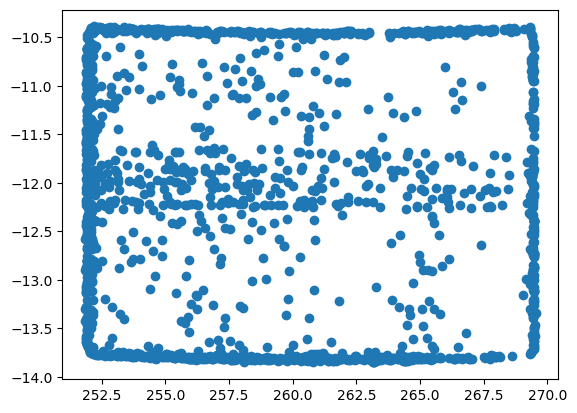

In [12]:
plt.scatter(result_hisnr['RA_d'].astype(float),result_hisnr['DEC_d'].astype(float))

In [13]:
result_inner=result_hisnr[(result_hisnr['RA_d'].astype(float)<267.8)*(result_hisnr['RA_d'].astype(float)>252.4)]
result_inner=result_inner[(result_hisnr['DEC_d'].astype(float)<-10.5)*(result_hisnr['DEC_d'].astype(float)>-13.7)]

/tmp/ipykernel_1099301/2859721495.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_inner=result_inner[(result_hisnr['DEC_d'].astype(float)<-10.5)*(result_hisnr['DEC_d'].astype(float)>-13.7)]


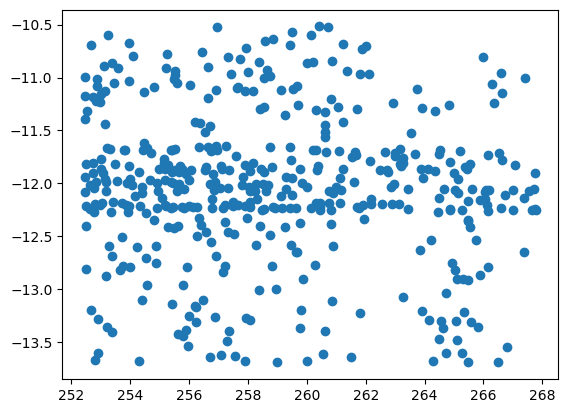

In [14]:
plt.scatter(result_inner['RA_d'].astype(float),result_inner['DEC_d'].astype(float))

In [15]:
vel=(1420405751.768-result_inner['FREQ'].astype(float))/1420405751.768*299792.458
result_hivel=result_inner[(vel<-120)+(vel>120)]

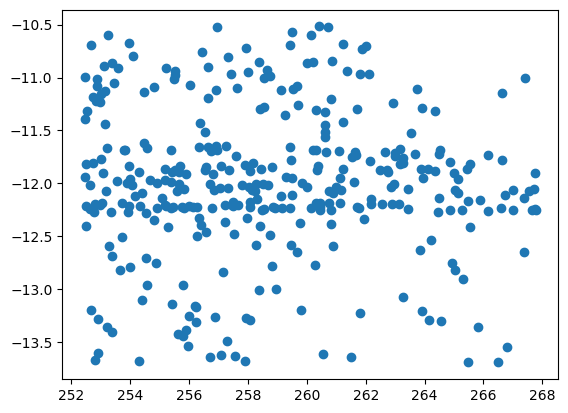

In [16]:
plt.scatter(result_hivel['RA_d'].astype(float),result_hivel['DEC_d'].astype(float))

In [17]:
result_hiersnr=result_hivel[resulttb['S/Nmax'].astype(float)>7]

/tmp/ipykernel_1099301/721361568.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_hiersnr=result_hivel[resulttb['S/Nmax'].astype(float)>7]


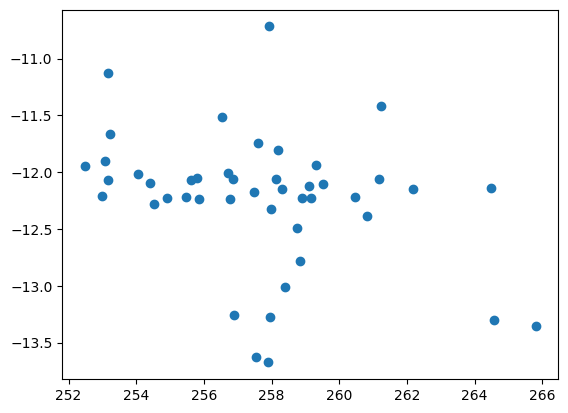

In [18]:
plt.scatter(result_hiersnr['RA_d'].astype(float),result_hiersnr['DEC_d'].astype(float))

In [19]:
vel=(1420405751.768-result_hiersnr['FREQ'].astype(float))/1420405751.768*299792.458

(12, 45, 49)


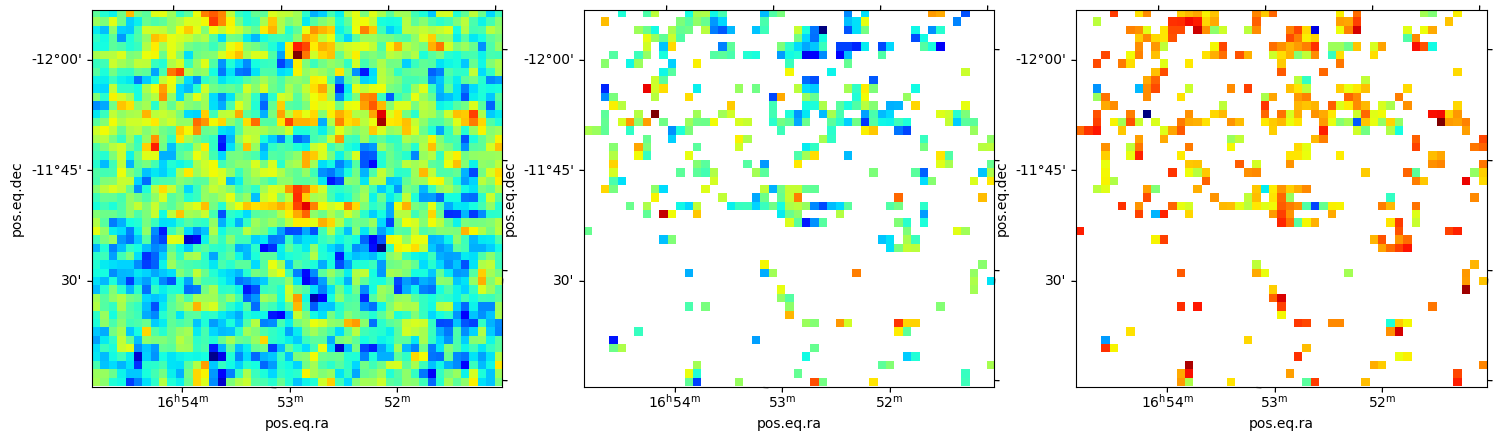

In [20]:
from spectral_cube import SpectralCube
import astropy.units as u
cube=SpectralCube.read('GCHVC_imcontsub.fits')
for idx in result_hiersnr.index[:1]:
    X1,X2=int(result_hiersnr['X1'][idx]),int(result_hiersnr['X2'][idx])
    Y1,Y2=int(result_hiersnr['Y1'][idx]),int(result_hiersnr['Y2'][idx])
    Z1,Z2=int(result_hiersnr['Z1'][idx]),int(result_hiersnr['Z2'][idx])
    Xm,XM=max(0,X1-20),min(cube.shape[2],X2+20)
    Ym,YM=max(0,Y1-20),min(cube.shape[1],Y2+20)
    cube_sub=cube[Z1:Z2,Ym:YM,Xm:XM]
    print(cube_sub.shape)
    cube_sub=cube_sub.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=float(result_hiersnr['FREQ'][idx])*u.Hz)
    mmt0=cube_sub.with_spectral_unit(u.km/u.s).moment(order=0)
    mmt1=cube_sub.with_spectral_unit(u.km/u.s).moment(order=1)
    mmt2=cube_sub.with_spectral_unit(u.km/u.s).moment(order=2)
    m0cu=mmt0.hdu.data
    hispix=m0cu-np.nanmean(m0cu)>0.03*(Z2-Z1)
    mmt1.hdu.data[~hispix]=np.nan
    mmt2.hdu.data[~hispix]=np.nan
    fig=plt.figure(figsize=[18,6])
    ax=fig.add_subplot(131,projection=mmt0.wcs)
    im=ax.imshow(mmt0.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax=fig.add_subplot(132,projection=mmt1.wcs)
    im=ax.imshow(mmt1.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax=fig.add_subplot(133,projection=mmt2.wcs)
    im=ax.imshow(mmt2.hdu.data,cmap='jet')
    ax.invert_yaxis()
    plt.savefig('figs/%s_moments.pdf'%(result_hiersnr['Name'][idx]))

(7, 44, 45)


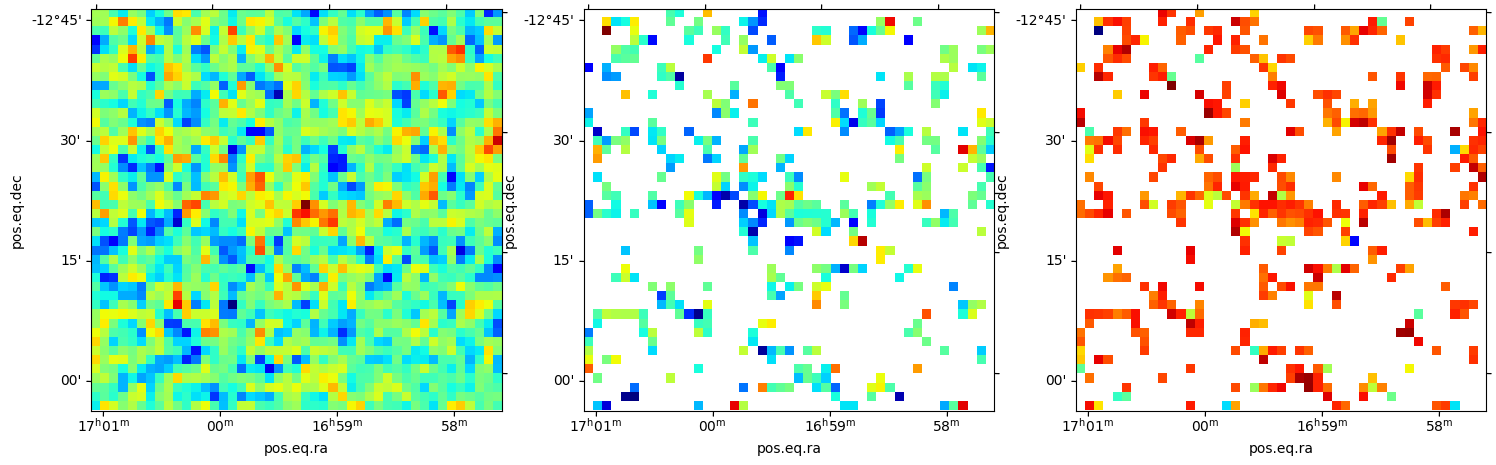

 n


/tmp/ipykernel_1099301/3590976600.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_hivel['Flag'][idx]=input()


In [21]:
cube=SpectralCube.read('GCHVC_imcontsub.fits')
%matplotlib inline
for idx in result_hivel.index[:1]:
    X1,X2=int(result_hivel['X1'][idx]),int(result_hivel['X2'][idx])
    Y1,Y2=int(result_hivel['Y1'][idx]),int(result_hivel['Y2'][idx])
    Z1,Z2=int(result_hivel['Z1'][idx]),int(result_hivel['Z2'][idx])
    Xm,XM=max(0,X1-20),min(cube.shape[2],X2+20)
    Ym,YM=max(0,Y1-20),min(cube.shape[1],Y2+20)
    cube_sub=cube[Z1:Z2,Ym:YM,Xm:XM]
    print(cube_sub.shape)
    cube_sub=cube_sub.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=float(result_hivel['FREQ'][idx])*u.Hz)
    mmt0=cube_sub.with_spectral_unit(u.km/u.s).moment(order=0)
    mmt1=cube_sub.with_spectral_unit(u.km/u.s).moment(order=1)
    mmt2=cube_sub.with_spectral_unit(u.km/u.s).moment(order=2)
    m0cu=mmt0.hdu.data
    hispix=m0cu-np.nanmean(m0cu)>0.03*(Z2-Z1)
    mmt1.hdu.data[~hispix]=np.nan
    mmt2.hdu.data[~hispix]=np.nan
    fig=plt.figure(figsize=[18,6])
    ax=fig.add_subplot(131,projection=mmt0.wcs)
    im=ax.imshow(mmt0.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax=fig.add_subplot(132,projection=mmt1.wcs)
    im=ax.imshow(mmt1.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax=fig.add_subplot(133,projection=mmt2.wcs)
    im=ax.imshow(mmt2.hdu.data,cmap='jet')
    ax.invert_yaxis()
    plt.show()
    result_hivel['Flag'][idx]=input()
    plt.close()
    #plt.savefig('figs/%s_moments_SN5.pdf'%(result_hivel['Name'][idx]))

In [22]:
result_select=result_hivel[result_hivel['Flag']=='y']

In [23]:
#result_select.to_csv('targets_select.csv',sep=',',index=False)
result_select=pd.read_csv('targets_select.csv',sep=',')

(52, 48, 54)
(93, 45, 55)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(60, 63, 55)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(29, 43, 46)


(107, 132, 98)


(22, 44, 46)


(141, 65, 66)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(23, 43, 43)


(21, 44, 44)


(55, 54, 54)


(100, 75, 60)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(7, 42, 43)


(18, 43, 43)


(83, 60, 57)


(8, 43, 44)


(38, 44, 47)


(47, 53, 53)


(32, 44, 46)


(37, 48, 52)


(55, 50, 52)


(27, 44, 45)


/tmp/ipykernel_1099301/4046941692.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=[18,6])


(44, 49, 55)


(12, 43, 43)


(29, 50, 46)


(26, 45, 45)


(67, 56, 56)


(136, 75, 65)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(73, 72, 63)


(71, 64, 66)


(21, 44, 45)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(52, 41, 48)


/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/zj/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:178: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * (pix_cen - mom1) ** order, axis=axis) /


(142, 62, 69)


(8, 43, 43)


(7, 43, 44)


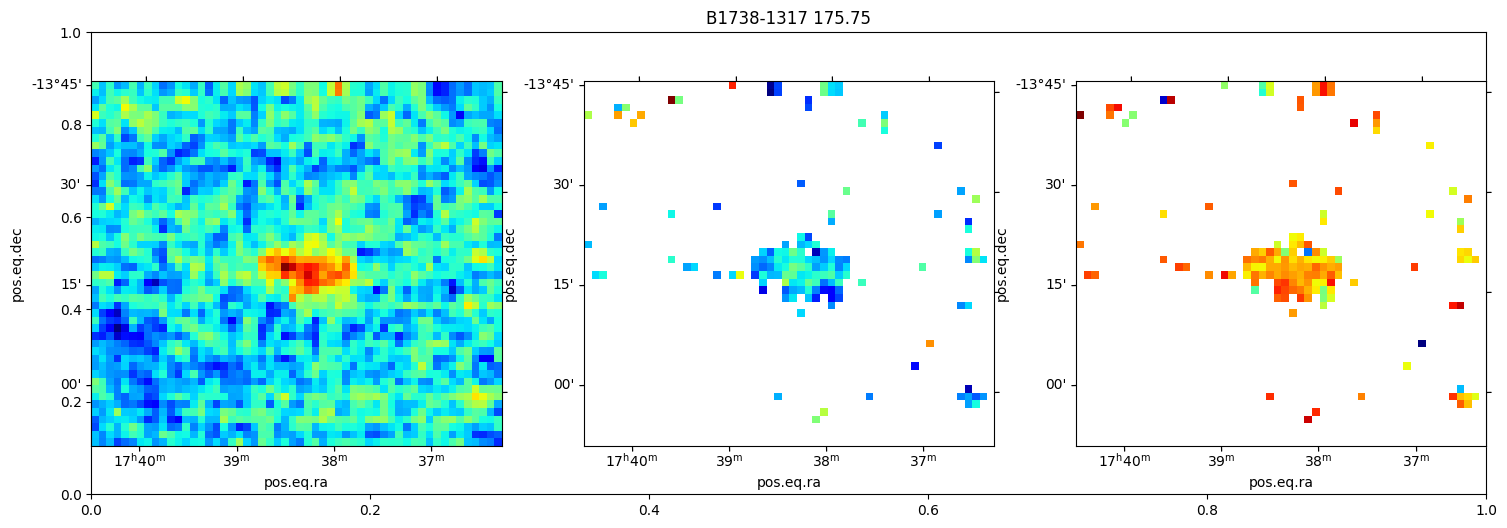

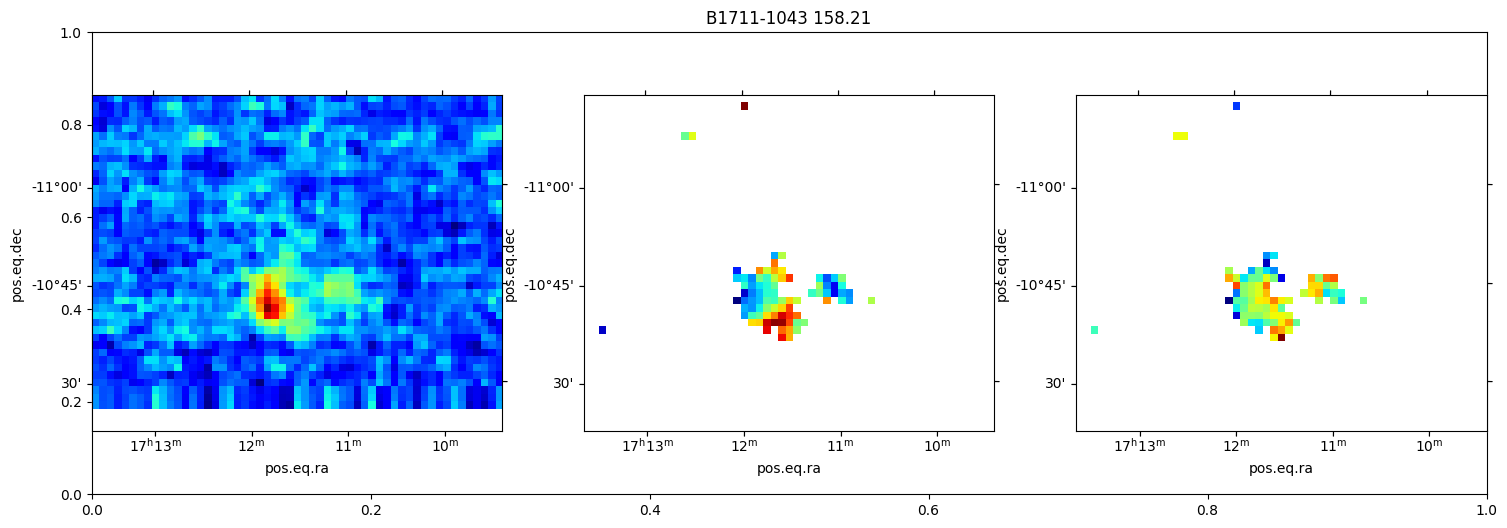

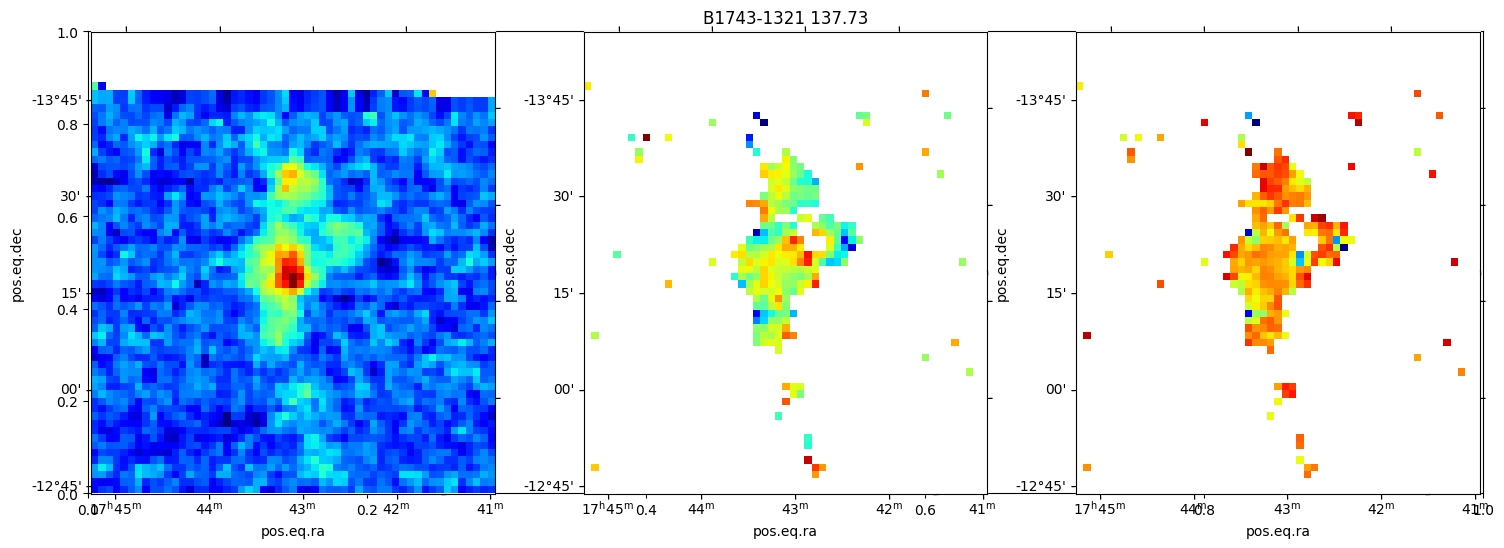

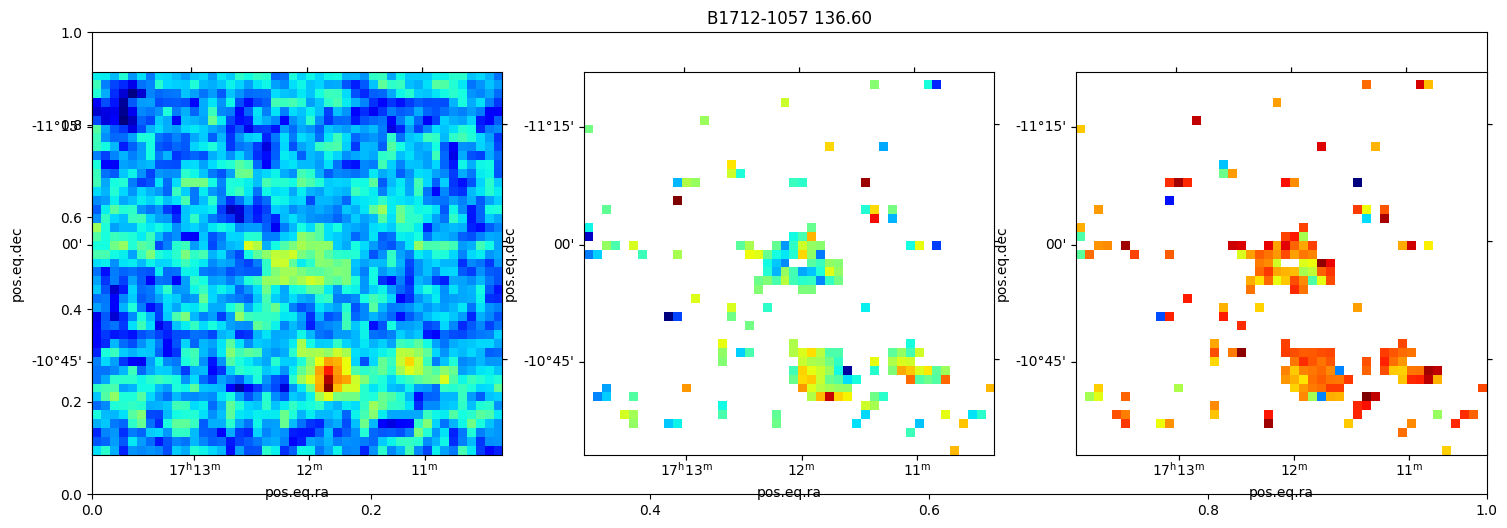

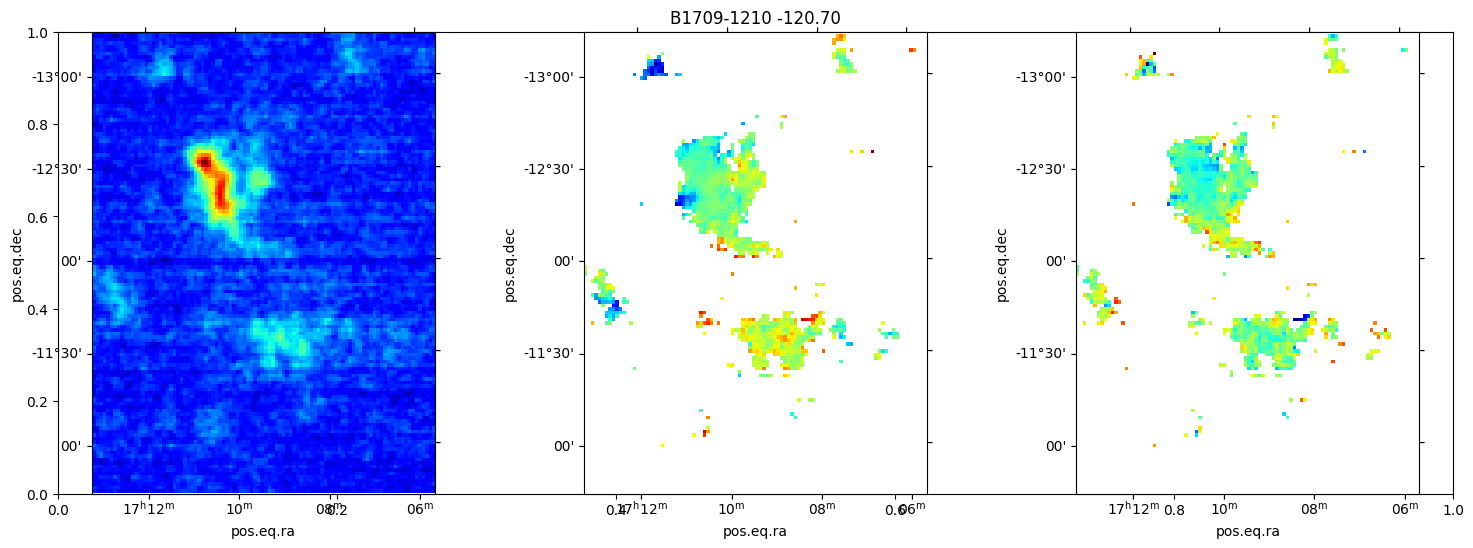

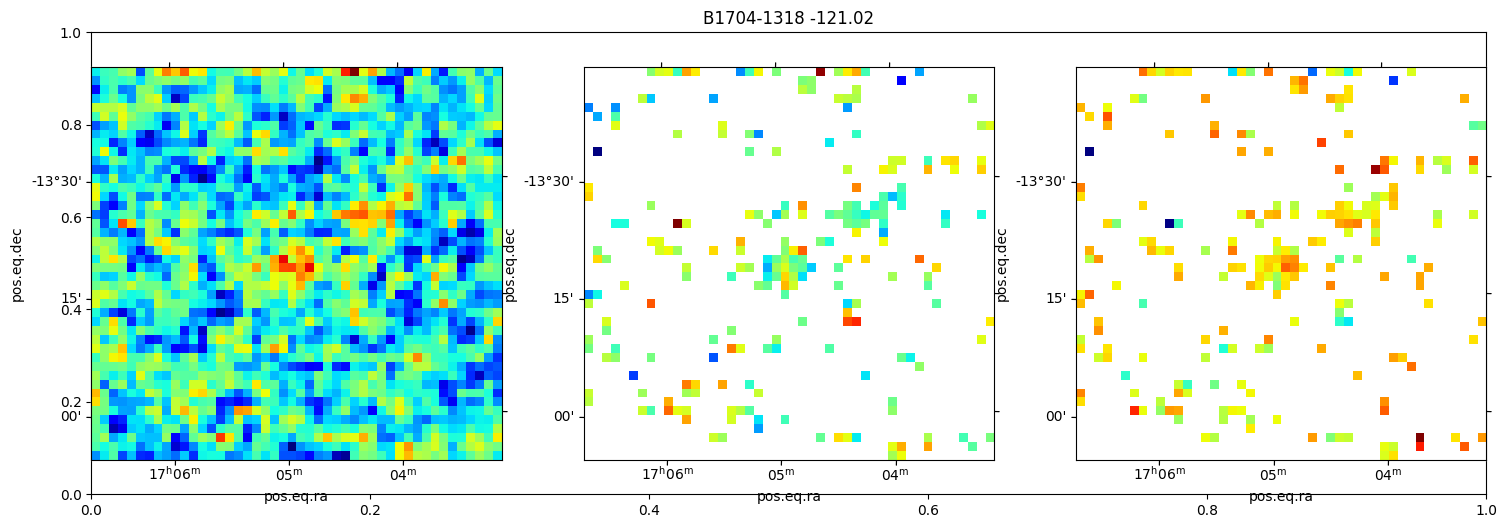

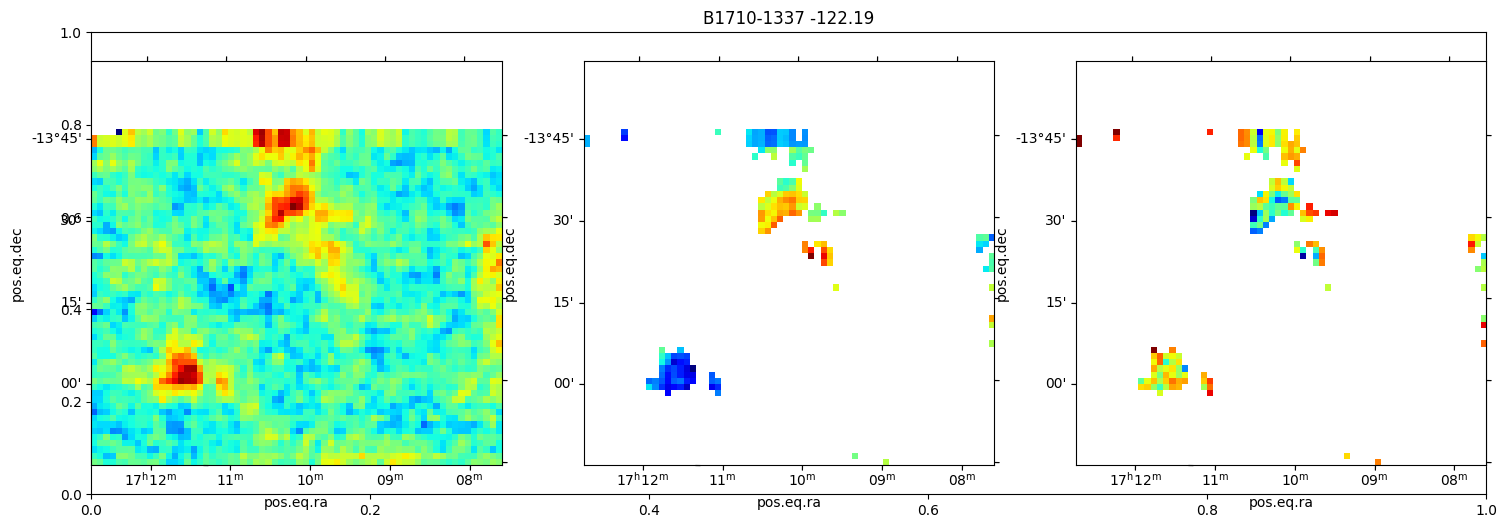

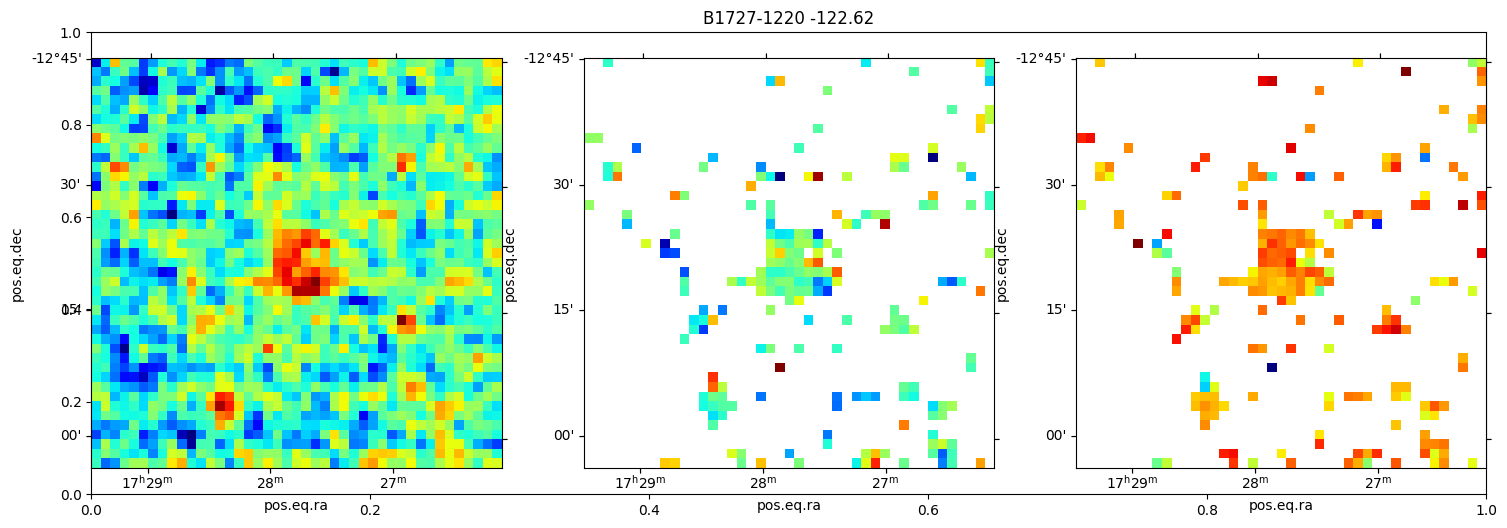

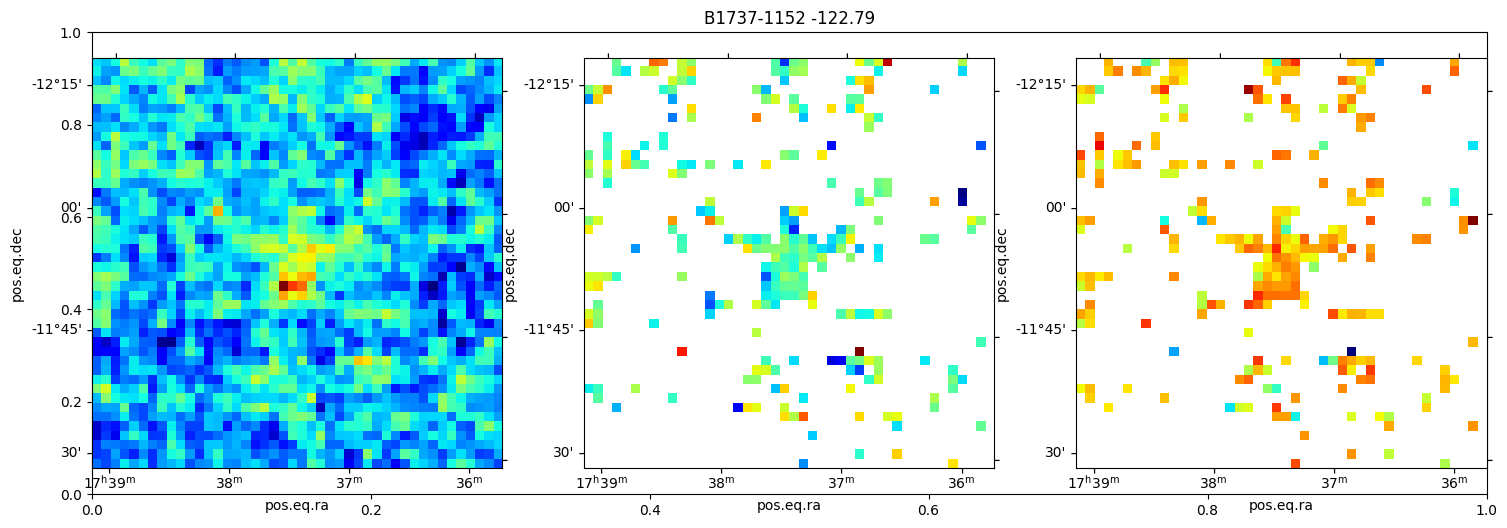

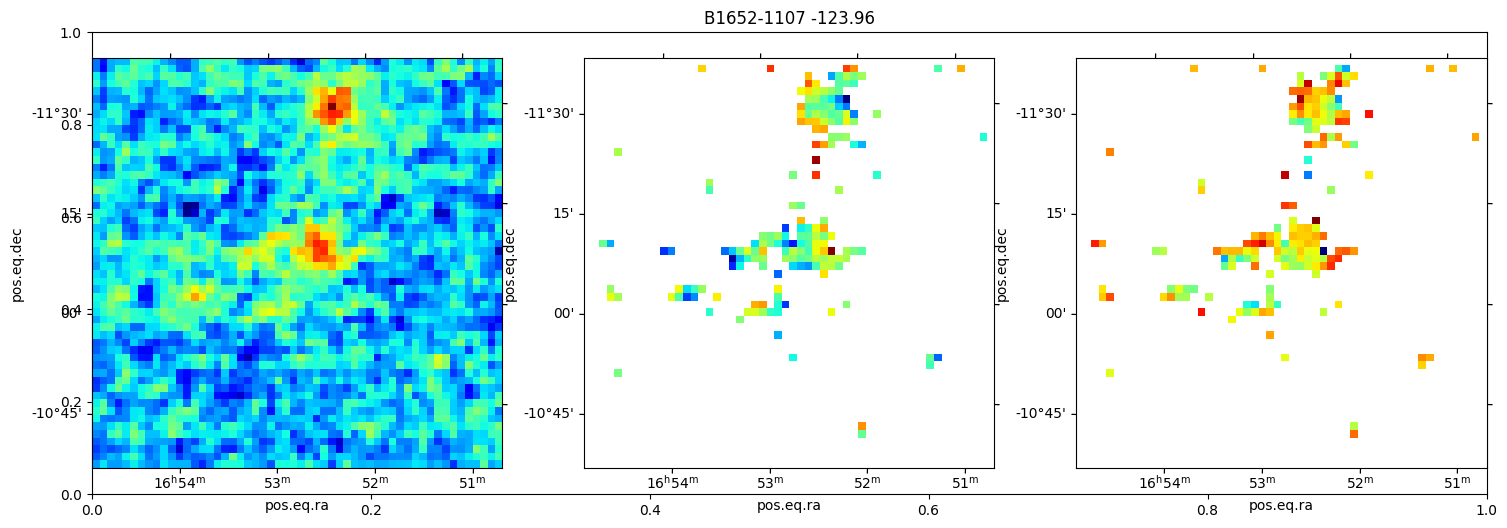

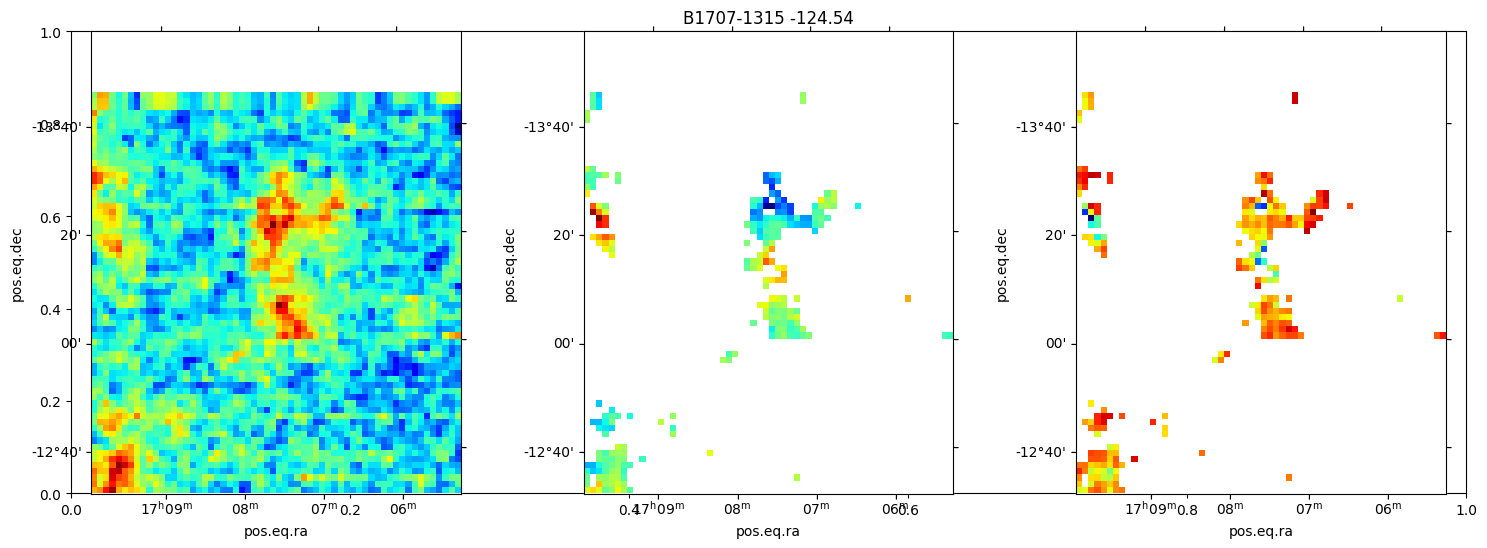

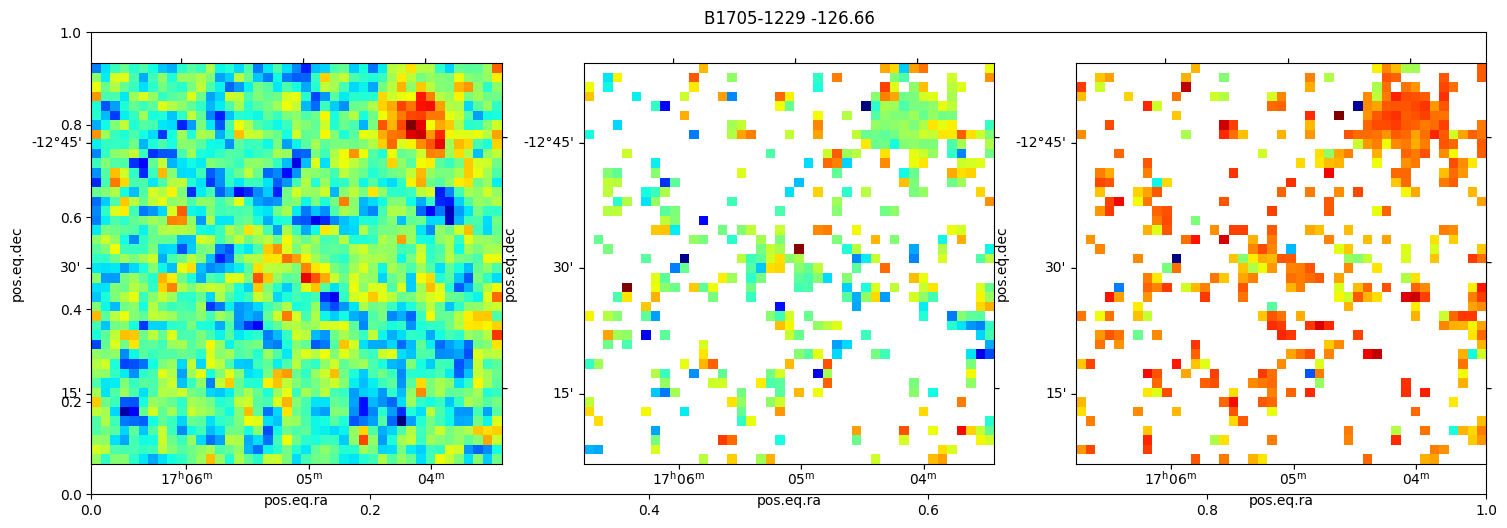

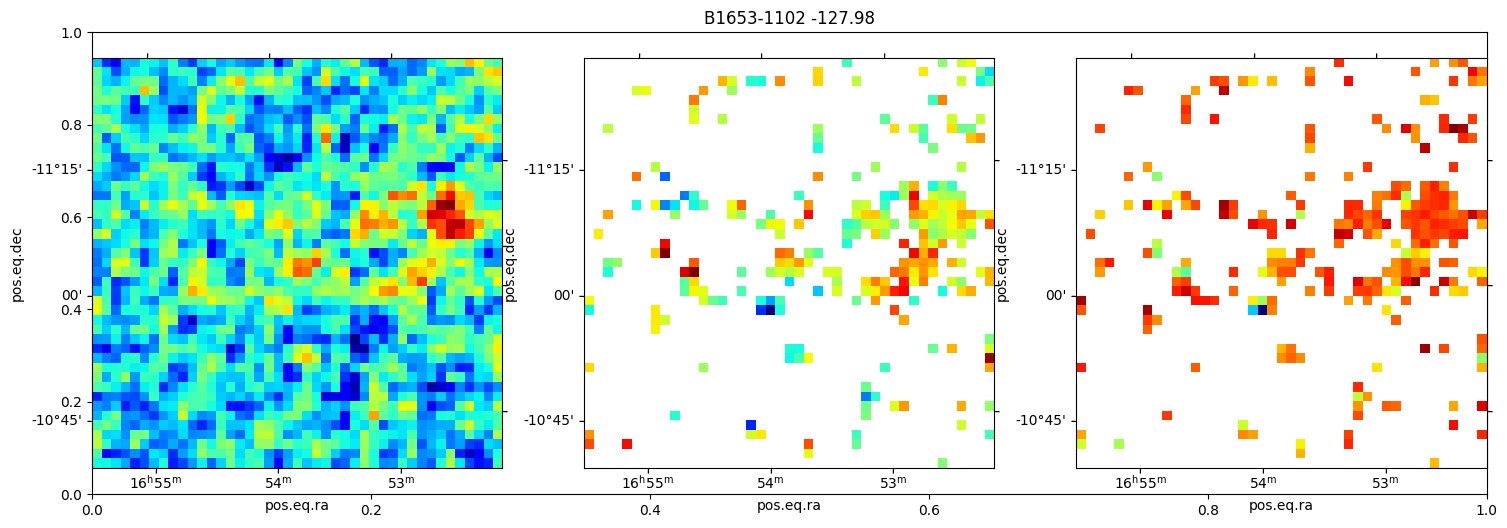

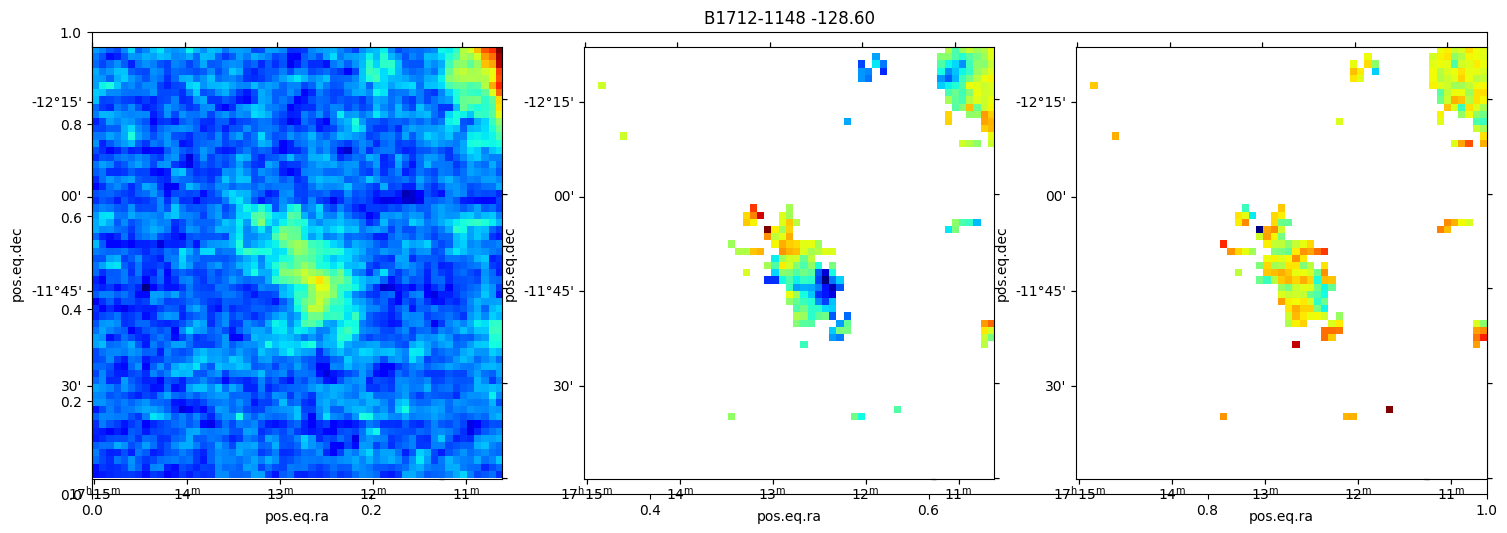

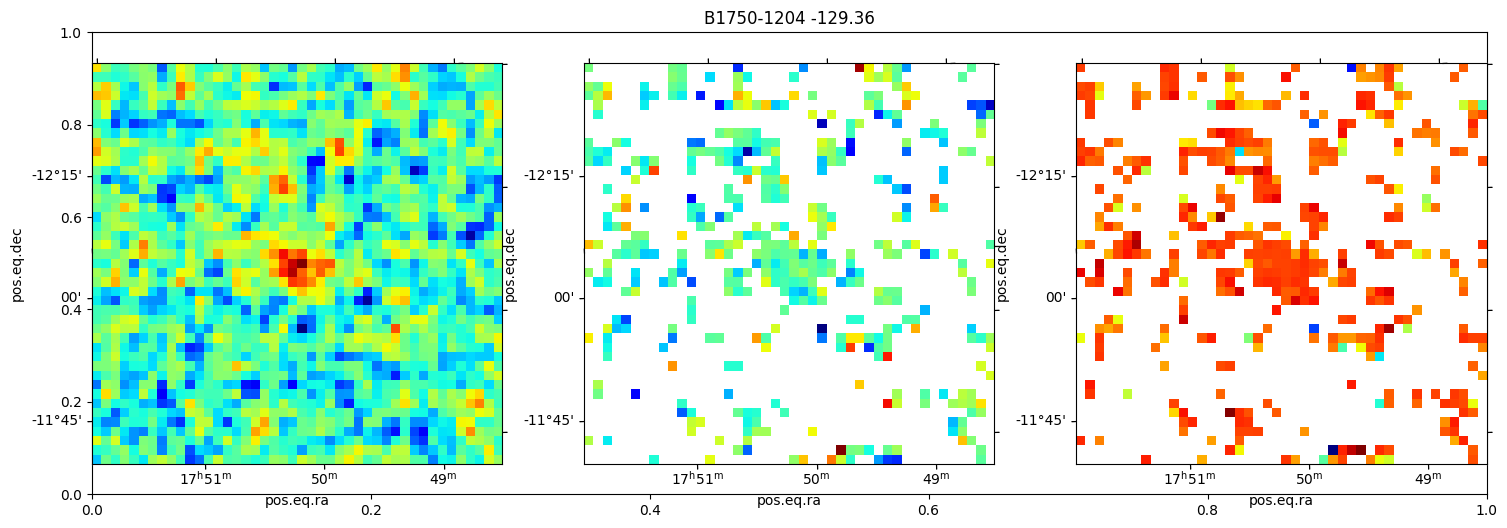

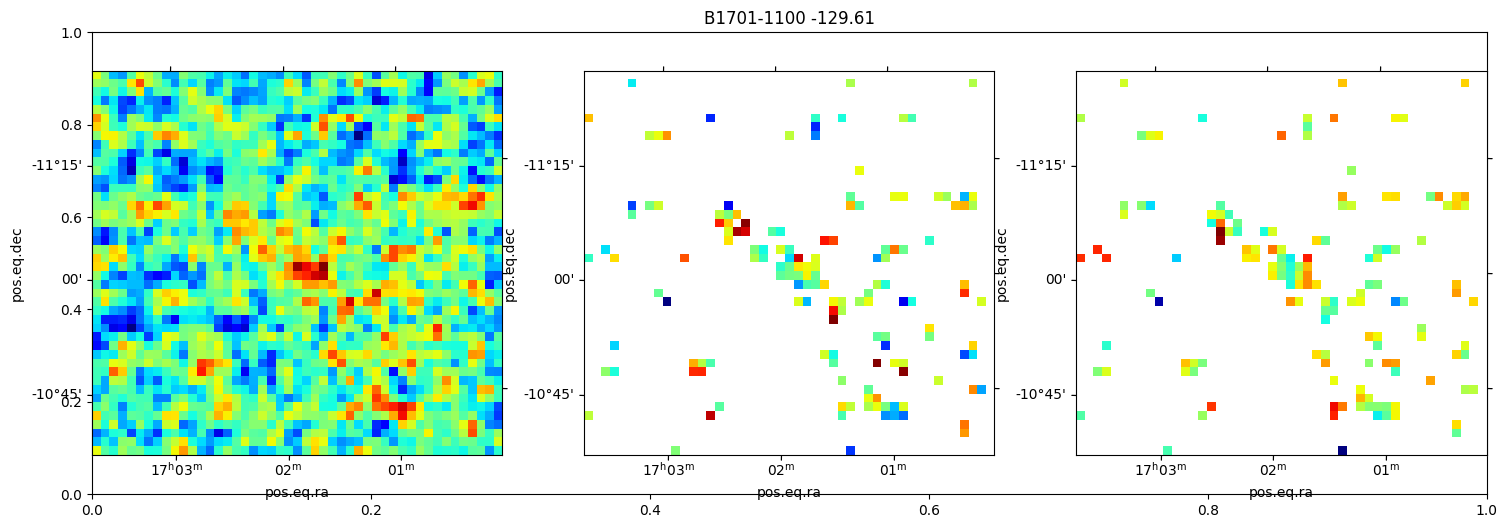

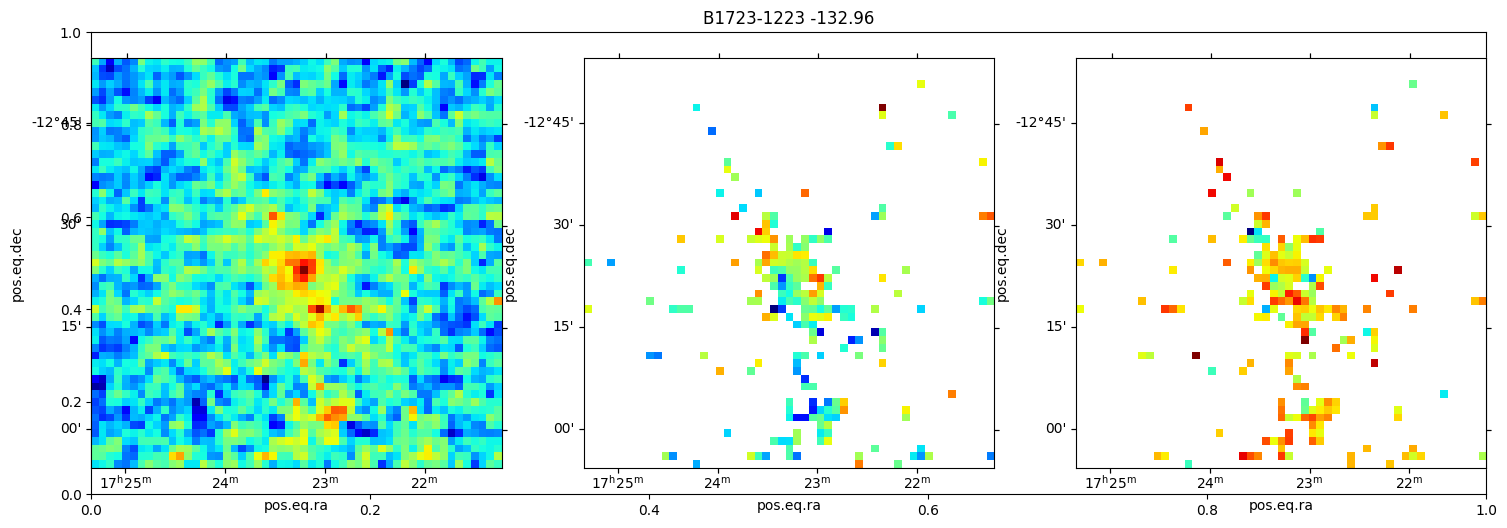

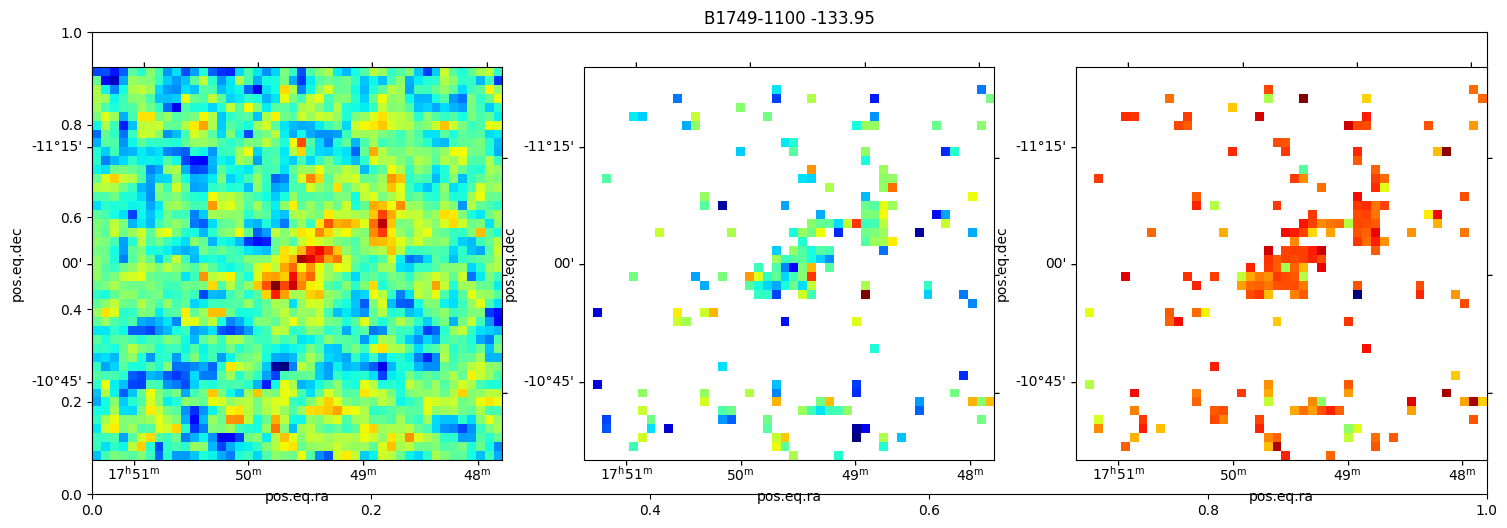

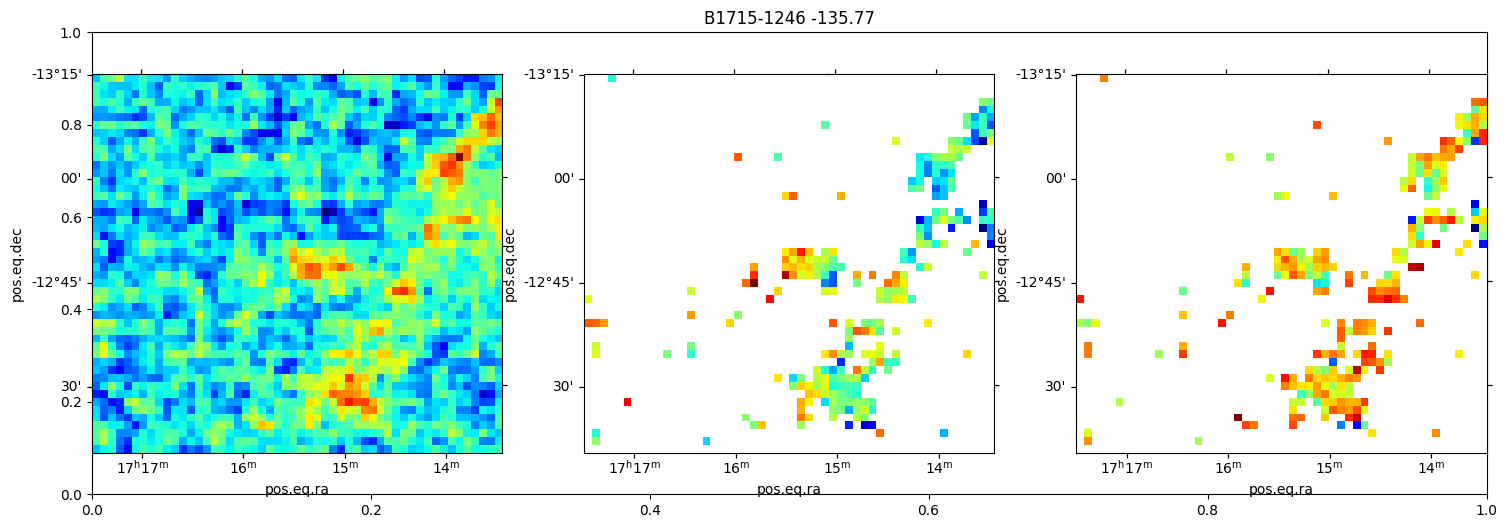

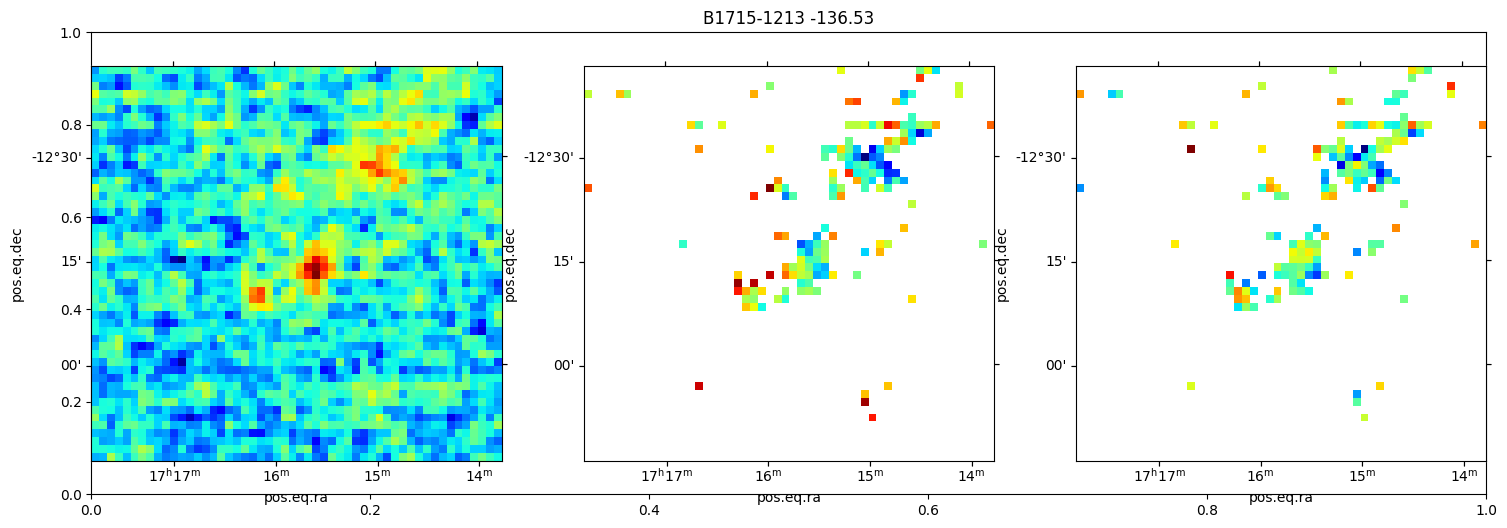

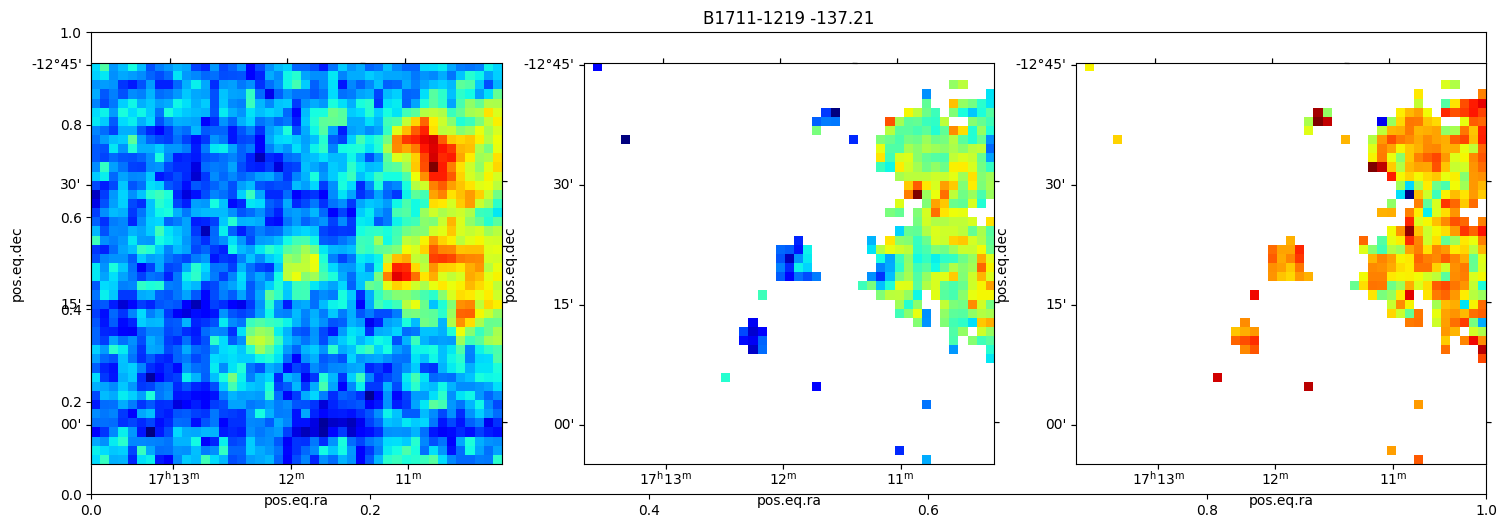

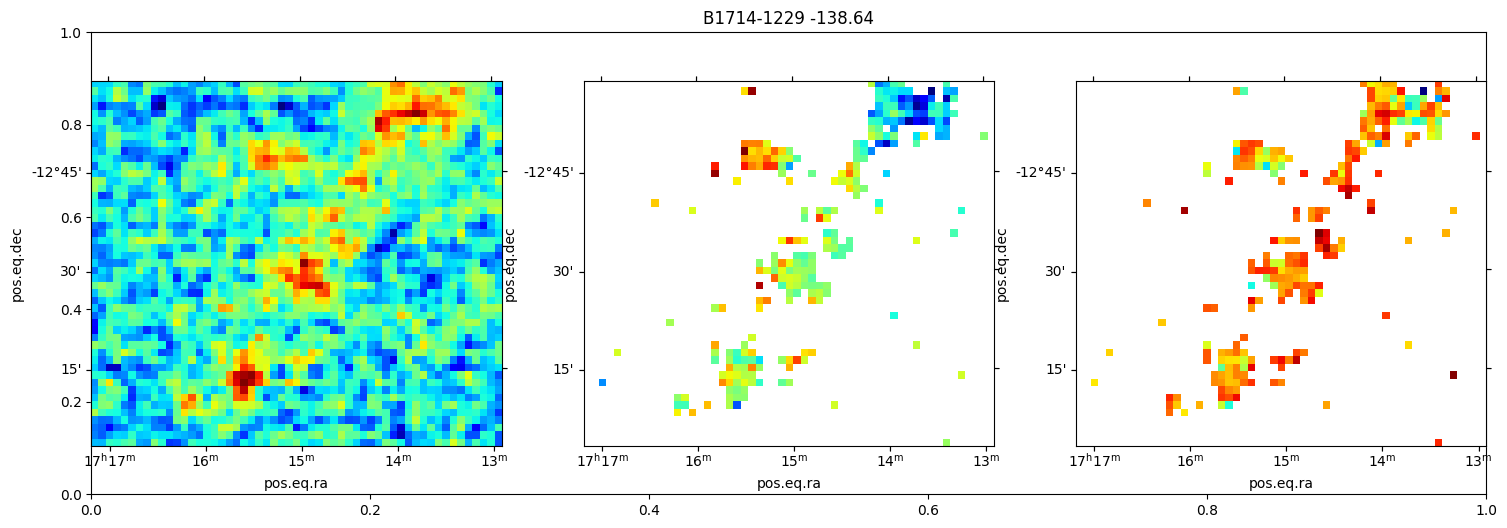

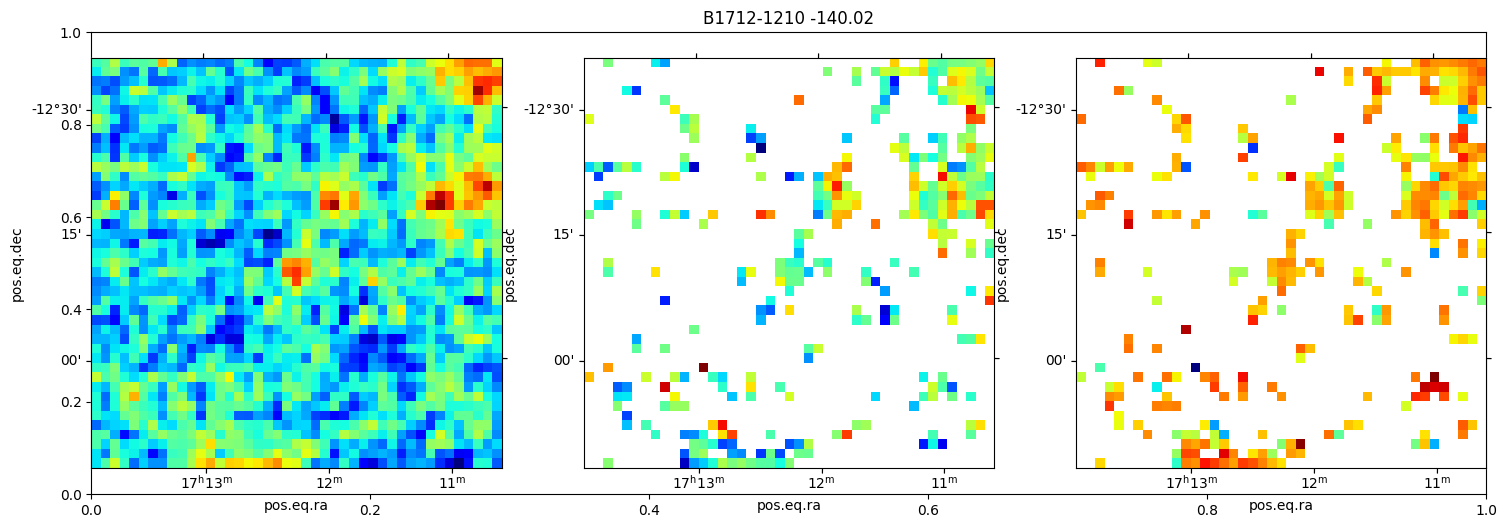

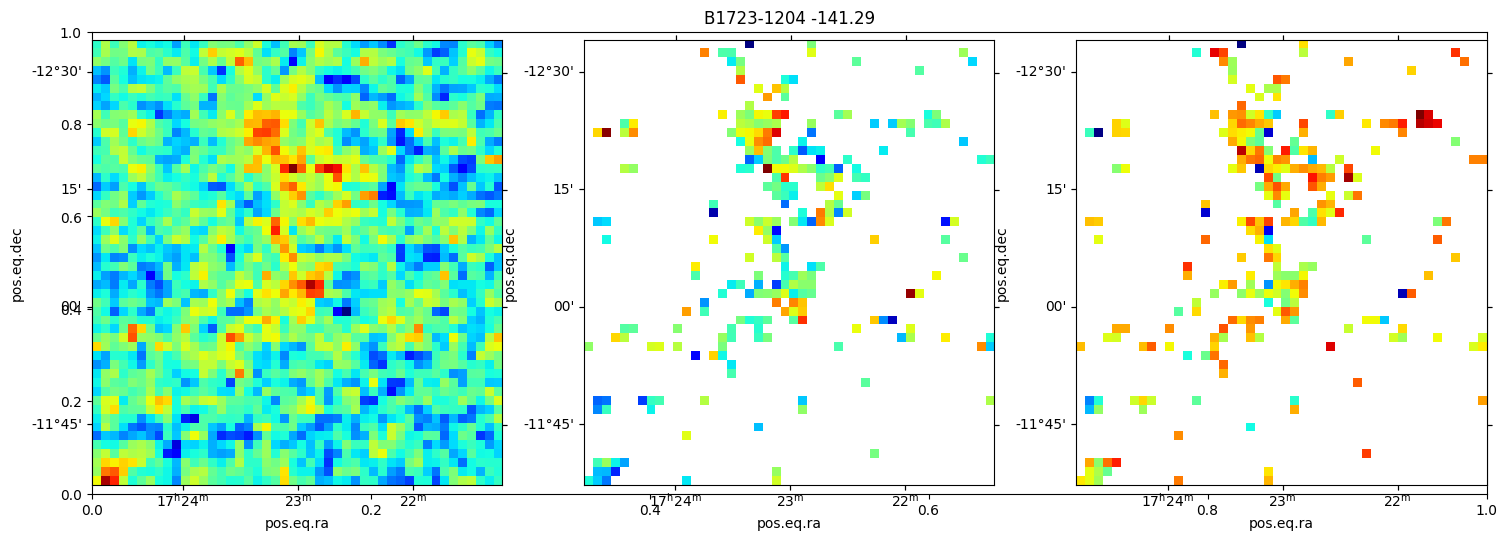

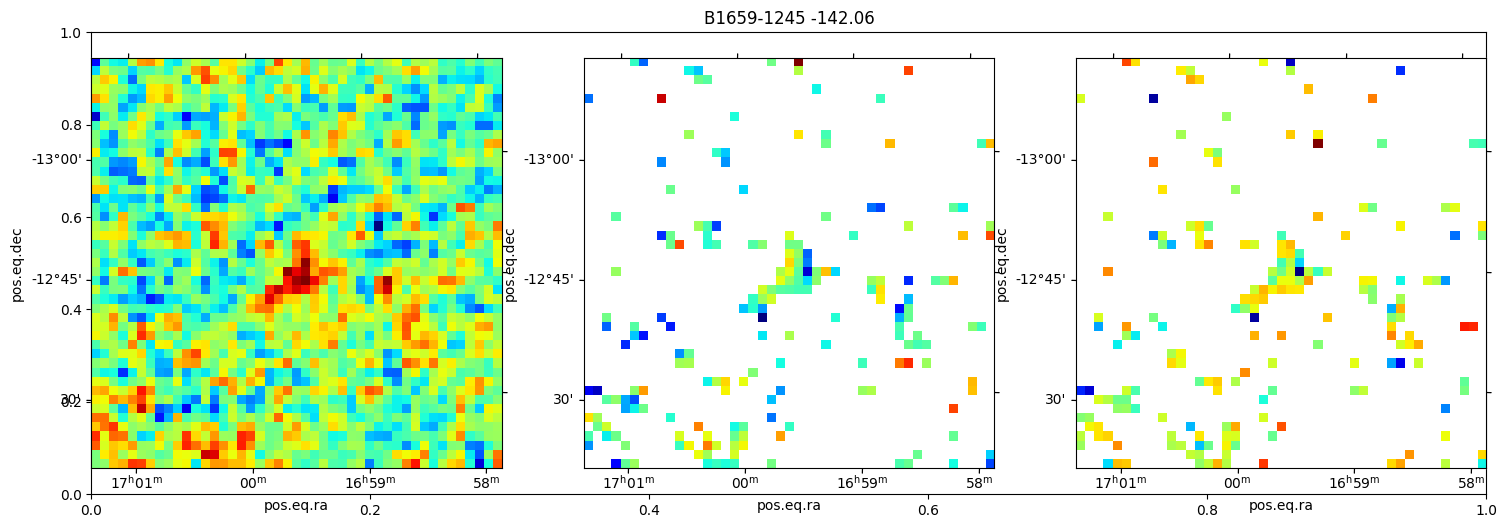

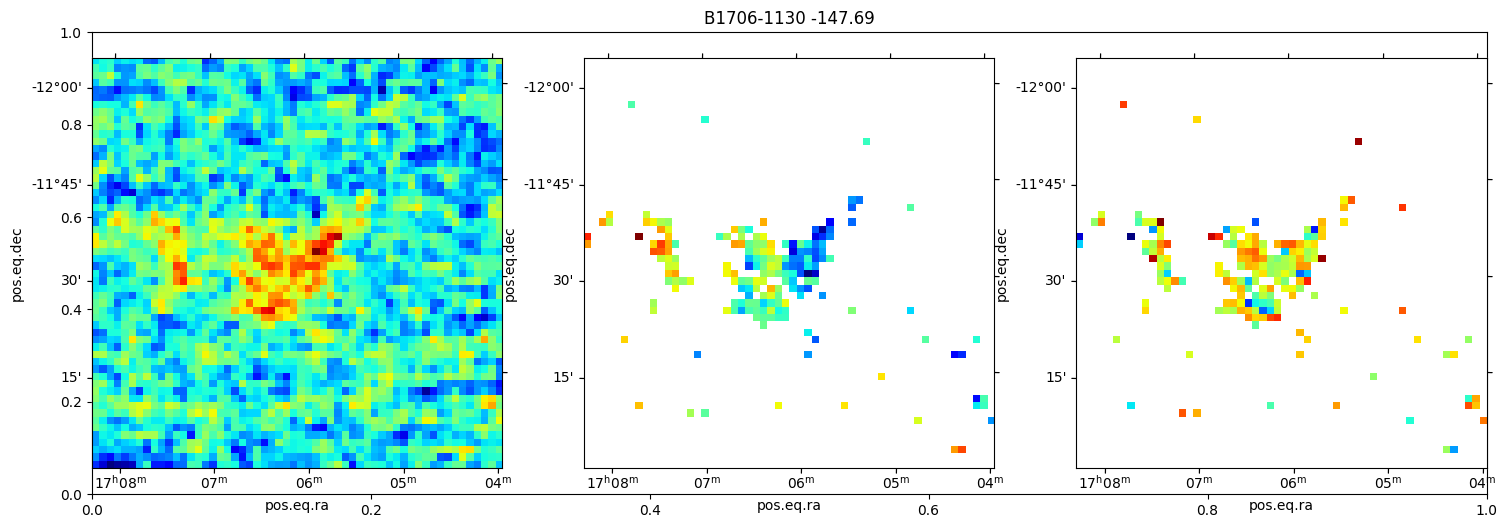

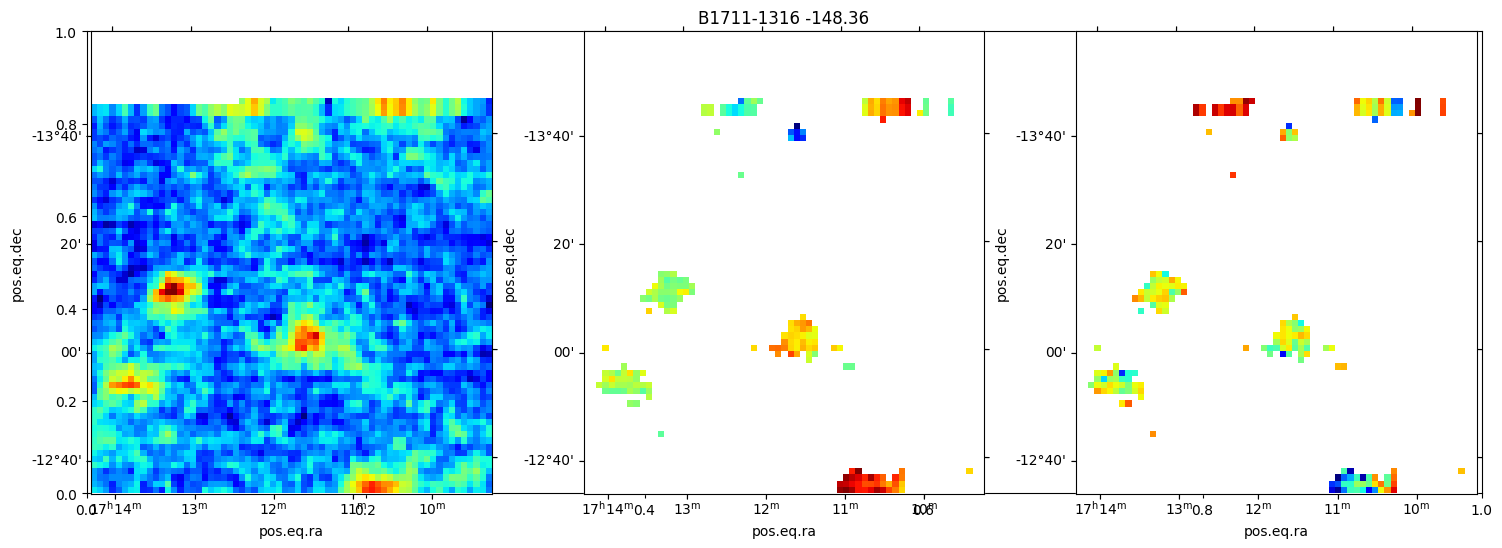

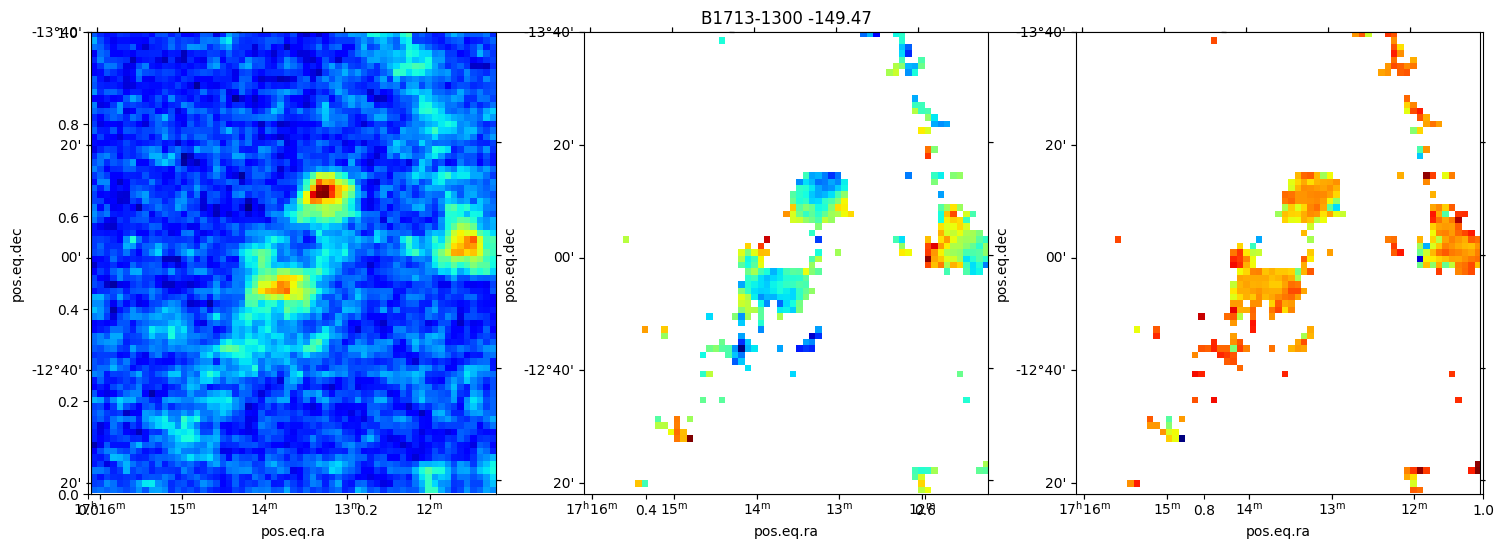

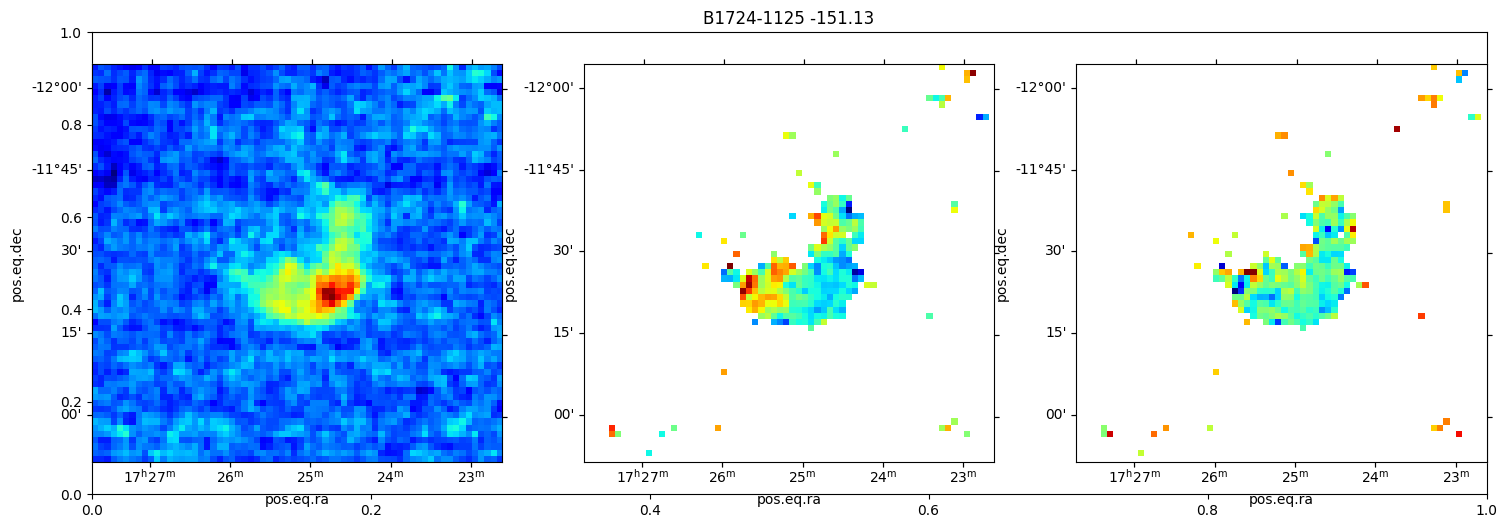

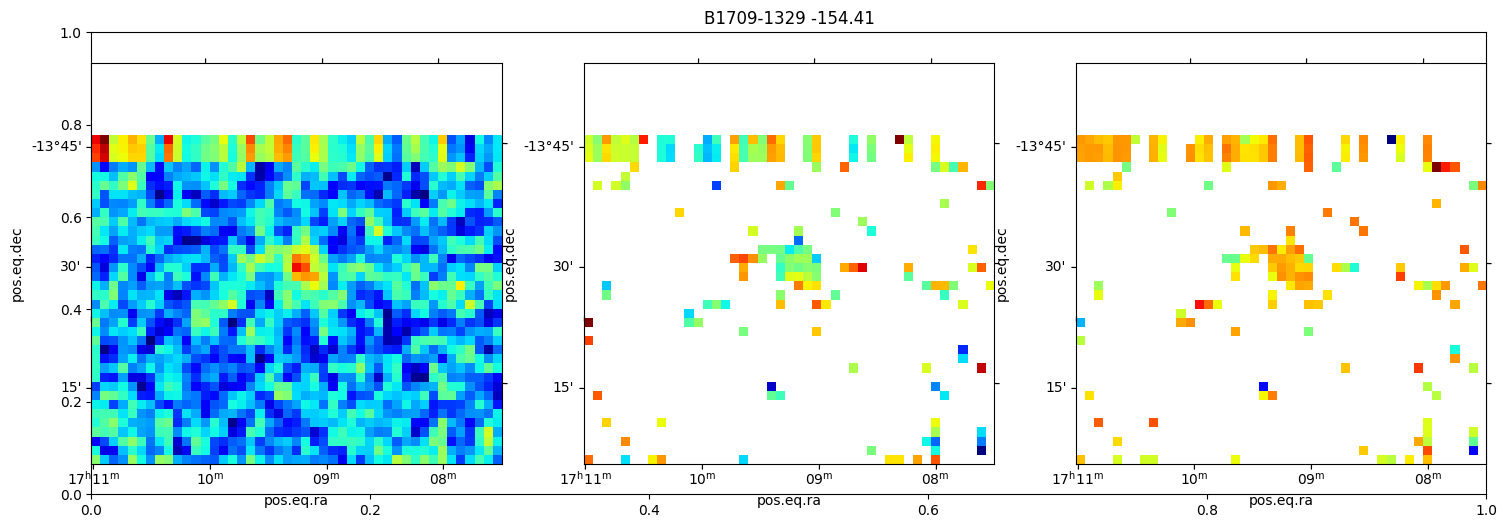

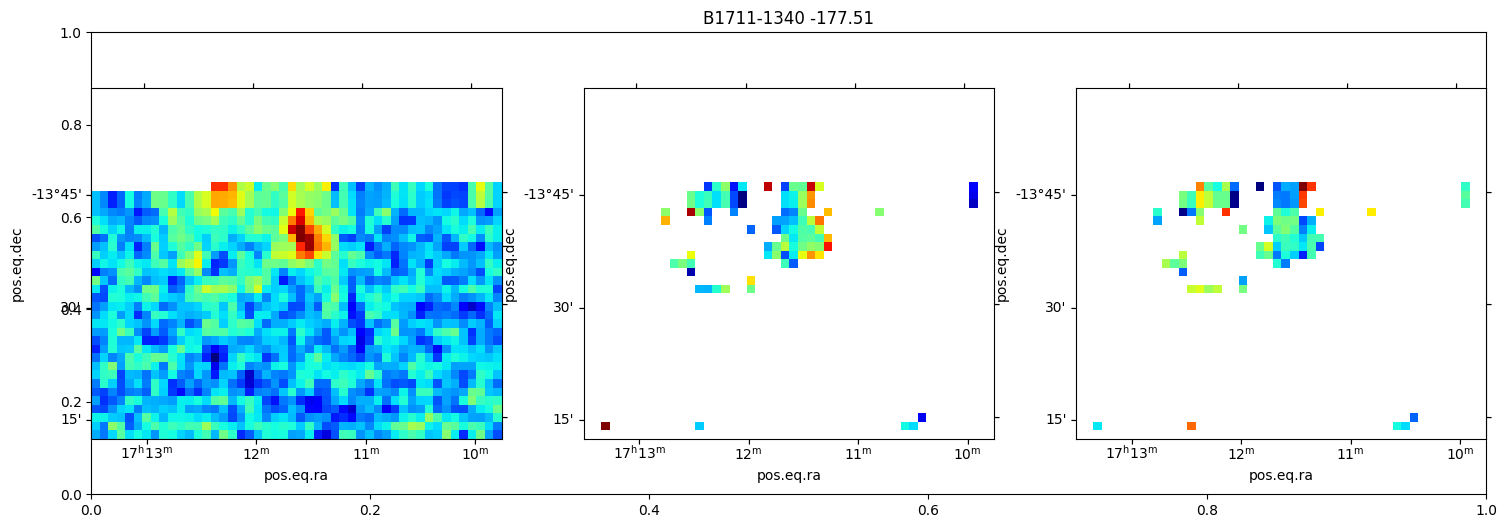

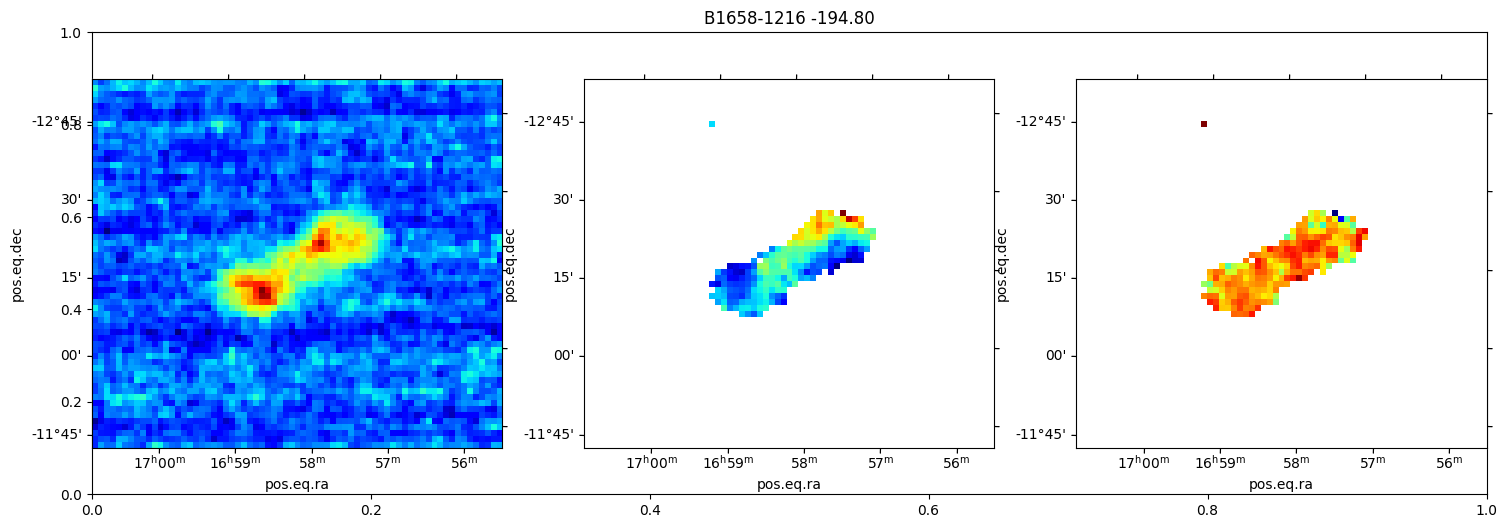

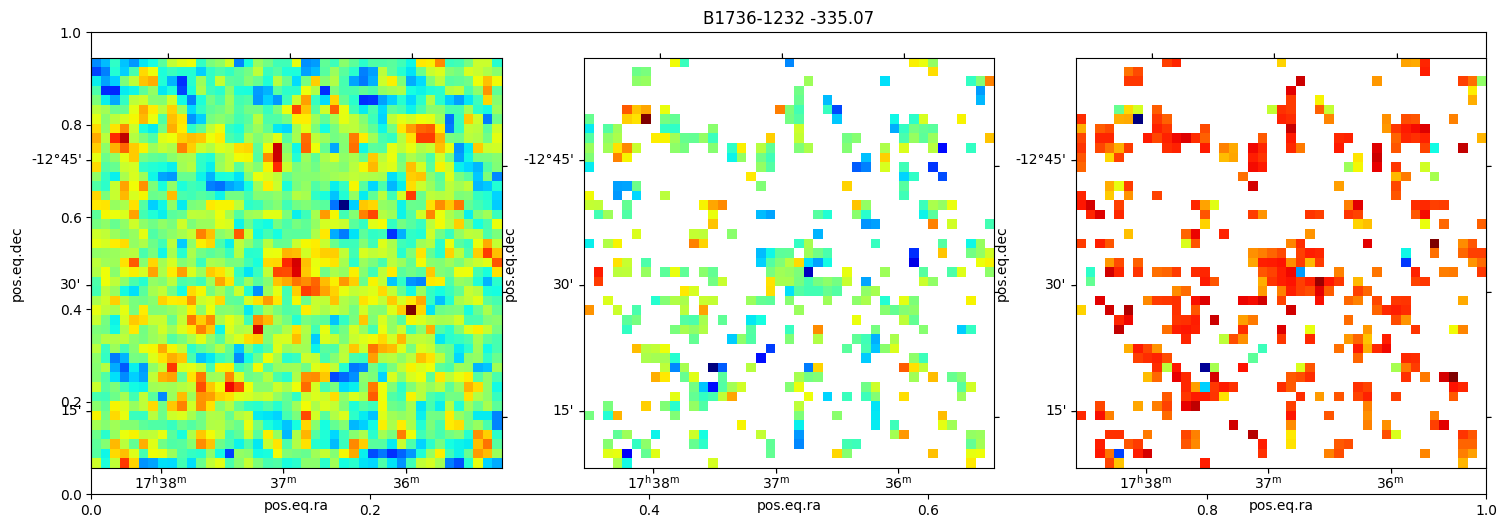

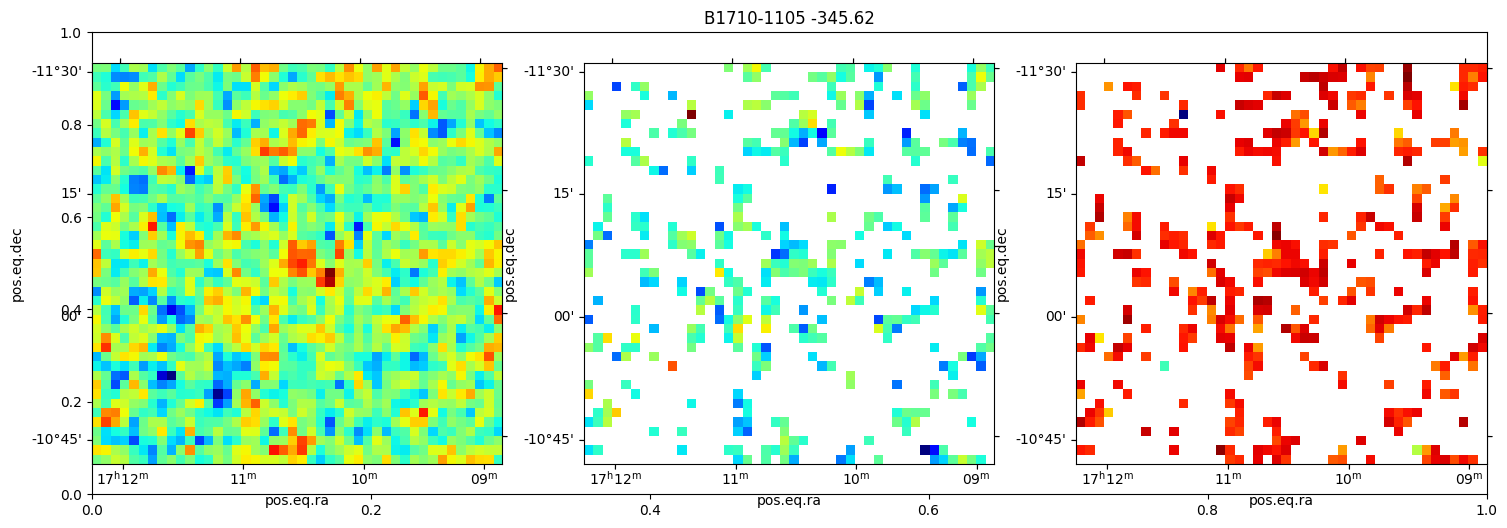

In [24]:
cube=SpectralCube.read('GCHVC_imcontsub.fits')
%matplotlib inline
for idx in result_select.index:
    X1,X2=int(result_select['X1'][idx]),int(result_select['X2'][idx])
    Y1,Y2=int(result_select['Y1'][idx]),int(result_select['Y2'][idx])
    Z1,Z2=int(result_select['Z1'][idx]),int(result_select['Z2'][idx])
    Xm,XM=max(0,X1-20),min(cube.shape[2],X2+20)
    Ym,YM=max(0,Y1-20),min(cube.shape[1],Y2+20)
    cube_sub=cube[Z1:Z2,Ym:YM,Xm:XM]
    vel=(1420405751.768-float(result_select['FREQ'][idx]))/1420405751.768*299792.458
    print(cube_sub.shape)
    cube_sub=cube_sub.with_spectral_unit(u.km/u.s,velocity_convention='radio',rest_value=float(result_select['FREQ'][idx])*u.Hz)
    mmt0=cube_sub.with_spectral_unit(u.km/u.s).moment(order=0)
    mmt1=cube_sub.with_spectral_unit(u.km/u.s).moment(order=1)
    mmt2=cube_sub.with_spectral_unit(u.km/u.s).moment(order=2)
    m0cu=mmt0.hdu.data
    hispix=m0cu-np.nanmean(m0cu)>0.03*(Z2-Z1)
    mmt1.hdu.data[~hispix]=np.nan
    mmt2.hdu.data[~hispix]=np.nan
    fig=plt.figure(figsize=[18,6])
    plt.title(result_select['Name'][idx]+' %.2f'%vel)
    ax=fig.add_subplot(131,projection=mmt0.wcs)
    im=ax.imshow(mmt0.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax=fig.add_subplot(132,projection=mmt1.wcs)
    im=ax.imshow(mmt1.hdu.data,cmap='jet')
    ax.invert_yaxis()
    ax=fig.add_subplot(133,projection=mmt2.wcs)
    im=ax.imshow(mmt2.hdu.data,cmap='jet')
    ax.invert_yaxis()
    plt.savefig('figs/%s_moments_selected.pdf'%(result_select['Name'][idx]))
    #cube_sub.hdu.writeto('sub_fits/%s_sub.fits'%(result_select['Name'][idx]))